In [60]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline as Spline
import matplotlib as mpl
import seaborn as sns

In [61]:
sipp_2014_2021 = pd.read_csv(r"C:\Users\shell\Python stuff\SIPP data\SIPP_2014_2021.txt", index_col=0)
datalab = pd.read_csv(r"C:\Users\shell\Python stuff\DataLab Data\DataLab_bachelor_completed.csv")

C:\Users\shell\AppData\Local\Temp\ipykernel_28432\1422329980.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  sipp_2014_2021 = pd.read_csv(r"C:\Users\shell\Python stuff\SIPP data\SIPP_2014_2021.txt", index_col=0)


Functions intended for use with the SIPP data:

In [77]:
def median(dataframe, independent, dependent, point):
    '''
    Finds the median value of the dependent variable at the point given for the independent variable
    '''
    df = dataframe
    df = df[df[independent] == point]
    if df[dependent].median() > 0:
        return df[dependent].median()
    else:
        return -1

In [96]:
def average(list):
    if len(list) != 0:
        return sum(list) / len(list)
    else:
        return 0

def list_avg(dataframe, independent, dependent, point):
    '''
    Finds the average value of the dependent variable at the point given for the independent variable
    '''
    df = dataframe
    df = df[df[independent] == point]
    if average(df[dependent]) > 0:
        return average(df[dependent])
    else:
        return -1

In [93]:
def median_sort_by(dataframe, independent, dependent):
    '''
    Sorts a dataframe such that it compares the indpendent variable to the median of the dependent variable
    '''
    df = dataframe
    df = df.fillna(-1)
    df[independent] = df[independent].astype('int')
    df = df[(df['MONTHCODE'] == 1) & (df['EEDUC'] == 43) & (df[dependent] > 0) & (df[independent] > 0)]

    new_df = pd.DataFrame()
    new_df[independent] = range(df[independent].min(), (df[independent].max()+1))
    median_list = []
    for point in new_df[independent]:
        median_list.append(list_avg(df, independent, dependent, point))

    new_df['median ' + dependent] = median_list
    
    no_data_independent = []
    for x in new_df[independent]:
        if len(df[(df[dependent] == x)].index) < 10:
            no_data_independent.append(x)
    # new_df.drop(index=no_data_independent, axis='index', inplace=True)
    return new_df

In [91]:
def median_bar_graph(dataframe, independent, dependent, title, xlab, ylab):
    df = median_sort_by(dataframe, independent, dependent)
    plt.bar(df[independent], df['median ' + dependent])
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()

In [115]:
def median_spline(dataframe, independent, dependent, title, xlab, ylab):

    dataframe = median_sort_by(dataframe, independent, dependent)
    dependent = 'median ' + dependent
    x=np.linspace(dataframe[independent].min(), dataframe[independent].max(), 1000)
    spl = Spline(dataframe[independent], dataframe[dependent])
    plt.plot(x, spl(x))
    
    # fractions have no practical use, they're used for graph cleanliness
    dependent_fraction = (dataframe[dependent].max() - dataframe[dependent].min())*0.05
    independent_fraction = (dataframe[independent].max() - dataframe[independent].min())*0.05
    
    plt.ylim(dataframe[dependent].min() - dependent_fraction, dataframe[dependent].max() + dependent_fraction)
    plt.xlim(dataframe[independent].min() - independent_fraction, dataframe[independent].max() + independent_fraction)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    
    plt.show()

In [123]:
def median_regression(dataframe, independent, dependent, title, xlab, ylab, degree):
    '''
    Graphs the given dataframe and it's polynomial regression. 
    Dataframe must contain only the dependent and independent columns.
    '''
    dataframe = median_sort_by(dataframe, independent, dependent)
    dependent = 'median ' + dependent
    
    coefficients = np.polyfit(x=dataframe[independent], y=dataframe[dependent], deg=degree)
    function = np.poly1d(coefficients)
    
    x=np.linspace(dataframe[independent].min(), dataframe[independent].max(), 1000)
    y=function(x)
    
    # fractions have no practical use, they're used for graph cleanliness
    dependent_fraction = (dataframe[dependent].max() - dataframe[dependent].min())*0.05
    independent_fraction = (dataframe[independent].max() - dataframe[independent].min())*0.05
    
    plt.ylim(dataframe[dependent].min() - dependent_fraction, dataframe[dependent].max() + dependent_fraction)
    plt.xlim(dataframe[independent].min() - independent_fraction, dataframe[independent].max() + independent_fraction)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    
    plt.plot(x, y)
    plt.scatter(x=dataframe[independent], y=dataframe[dependent],s=20)
    
    plt.show

Functions intended for use with the NCES's NPSAS 2015-2016 data:

In [65]:
def datalab_round(dataframe):
    '''
    Rounds all values of the data to remove floating points
    '''
    df = dataframe
    df = df.fillna(-1)
    for x in range(3, len(df.index)):
        for y in range(1, len(df.columns)):
            df.iloc[x, y] = int(round(float(df.iloc[x, y]), 2))
    return df

In [66]:
def datalab_bar_graph(column, row_range, title, xlab, ylab):
    '''
    column must be a column from the dataframe, row_range must be a range() function
    '''
    df = datalab_round(datalab)
    plt.bar(df['Variable'].iloc[row_range], 
    df[df.iloc[:, range(1, 6)] != -1].iloc[row_range, datalab.columns.get_loc(column)])
    # discards -1 values from rounding process, replacing them with NAN values that are automaatically ignored by Pandas 
    
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show

## Comparing Data Sets

Since both the SIPP and NPSAS contain data on similar demographics and variables, with the only major distinction of SIPP being a household survey while NPSAS puts and emphasis on undergraduates

Let's start by comparing the data available on debt owed by a student's race.
Here's the data we have from the SIPP:

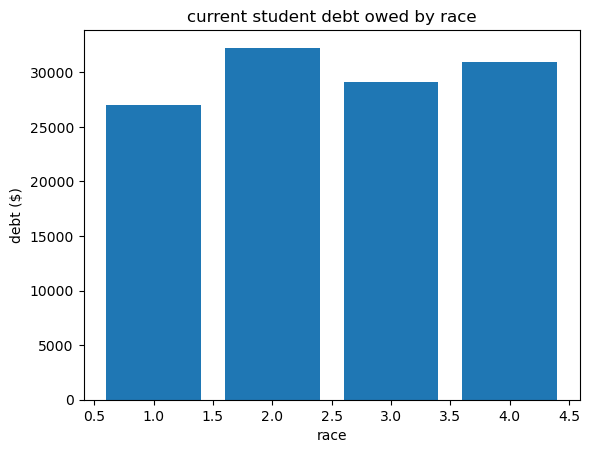

In [129]:
median_bar_graph(sipp_2014_2021[sipp_2014_2021['YEAR'] == 2014], 'ERACE', 'TOEDDEBTVAL', 'current student debt owed by race', 'race', 'debt ($)')

`1.0: White alone, 2.0: Black alone, 3.0: Asian alone`

Now let's compare this to the average from the NPSAS:

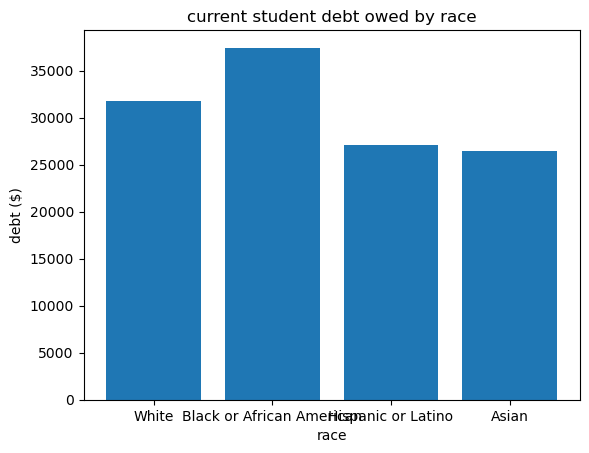

In [28]:
datalab_bar_graph('Amount still owed on all undergraduate loans', range(39, 43), 'current student debt owed by race', 'race', 'debt ($)')

Besides the amount of debt for asians, the results are pretty close, with white alone and black alone being only a few thousand higher. These higher values can be contributed to the NPSAS's focus on following undergraduates, making their demographic mainly younger people who generally have more debt as shown below:

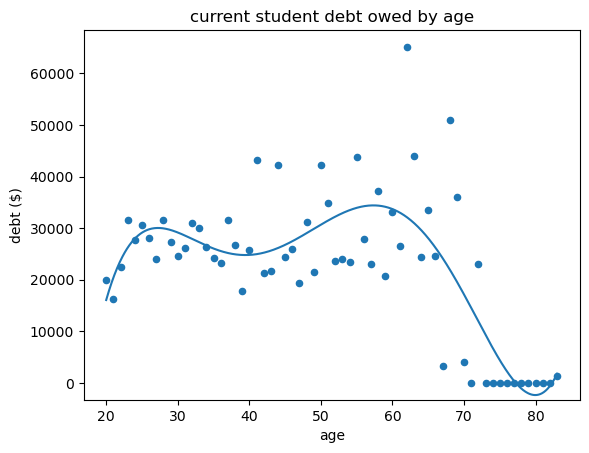

In [128]:
median_regression(sipp_2014_2021[sipp_2014_2021['YEAR'] == 2014], 'TAGE', 'TOEDDEBTVAL', 'current student debt owed by age', 'age', 'debt ($)', 5)